<a href="https://colab.research.google.com/github/manumeehl/trajectories/blob/main/Trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
''' SYSTEM AND PYTHON PACKAGES '''

!apt install tesseract-ocr
!pip install opencv-python-headless pytesseract pytube

from google.colab.patches import cv2_imshow as show
from pytesseract import image_to_string as img_to_str
from scipy.interpolate import interp1d
from pytube import YouTube, Playlist
from scipy.signal import find_peaks
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
import cv2
import re
import os

In [2]:
''' GENERIC PYTHON UTILITIES '''

def contains_substring(text:str, substrings:list):
  ''' Check if a string contains a substring from a list of strings '''
  for substring in substrings:
    if substring in text:
      return True
  return False

In [20]:
''' VIDEO UTILITIES '''

def get_video(url:str):
  ''' Download a Video from YouTube and save it as MP4 '''
  vid = YouTube(url)
  print(f"Downloading Video '{vid.streams[0].title}'")
  vid.streams.filter(progressive=True, file_extension='mp4')\
  .order_by('resolution').desc().first()\
  .download(output_path='temp', filename='launch.mp4')
  print('Download complete')
  vidfile = cv2.VideoCapture('temp/launch.mp4')
  props = {'title': vid.title,
           'date': vid.publish_date,
           'length': vid.length,
           'fps': vidfile.get(cv2.CAP_PROP_FPS)}
  return vidfile, props

def show_frame(vid, position):
  ''' Show a single frame from a video file '''
  # ToDo: Read the video here
  vid.set(cv2.CAP_PROP_POS_FRAMES, int(position))
  ret, frame = vid.read()
  show(frame)

In [4]:
''' TIME CONVERSION TOOLS '''

def clock_to_secs(clockstring):
  ''' Convert a mission clock string to an integer second value '''
  tense = -1 if clockstring[:2] == 't-' else 1
  # Remove the T+- sign
  clockstring = clockstring [2:]
  # Get the seconds
  units = clockstring.split(':')
  hours = int(units[0])
  minutes = int(units[1])
  seconds = int(units[2])

  return tense * (hours * 3600 + minutes * 60 + seconds)

def elapsed_secs(frame1, frame2, fps):
  ''' Get the time between two frames in a video '''
  return round((frame2 - frame1) / fps, 2)

In [38]:
''' VIDEO PROCESSING '''

def preprocess(frame):
  ''' Apply preprocessing filters to a frame '''
  return cv2.bitwise_not(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

def get_snippets(frame):
  ''' Cut out regions of interest and apply filters for OCR '''
  height, width, _ = frame.shape

  stage1 = preprocess(frame[height-80:height-40,50:300])
  stage2 = preprocess(frame[height-80:height-40,width-300:width-50])
  clock = preprocess(frame[height-110:height-20,int(width/2-100):int(width/2+100)])

  return clock, stage1, stage2

In [39]:
''' OCR PARSING AND DATA EXTRACTION '''

def parse_clock(text:str) -> str:
  ''' Extract mission clock, altitude and velocity from a given string '''
  mission_clock = re.findall(r't[+-]\d{2}:\d{2}:\d{2}', text.lower().replace(' ', ''))
  if mission_clock: return mission_clock[0]
  else: return None

def parse_trajectory(text:str) -> dict:
  ''' Extract altitude and velocity from a given string '''
  trajectory = None
  # Apply a blacklist
  for w in ['stage 1', 'stage 2', 'falcon 9', 'starlink']:
    text = text.replace(w, '')
  # Find all numbers in the string
  num_scan = re.findall(r'\d+(?:\.\d+)?', text.lower())
  vel, alt = interpret_trajectory_numbers(num_scan)
  return {'vel': vel, 'alt': alt}

def interpret_trajectory_numbers(numbers:list) -> list:
  ''' From a list of numbers, determine which is the velocity and which the altitude based on a few requirements '''
  # Convert all numbers to float and remove duplicates
  numbers = list(set([float(x) for x in numbers]))
  # Check if two numbers are available, else return default value
  if len(numbers) == 2:
    # When speed is zero, altitude is the larger number (shortly after liftoff)
    if 0.0 in numbers:
      return [0, max(numbers)]
    else:
      return [max(numbers), min(numbers)]
  else:
    return [0, 0]

def extract_data(vid: cv2.VideoCapture, scope=[], ocr_config='--psm 11'):
  ''' Collect all datapoints from a frame '''
  # Get the regions of interest
  try:
    ret, frame = vid.read()
    clockframe, frame_s1, frame_s2 = get_snippets(frame)
  except:
    return None, None, None

  # Scan for data
  clock = parse_clock(img_to_str(clockframe, config={}))
  # Trajectory is empty by default
  trj_s1, trj_s2 = {}, {}

  if 's1' in scope:
    trj_s1 = parse_trajectory(img_to_str(frame_s1, config=ocr_config))
  if 's2' in scope:
    trj_s2 = parse_trajectory(img_to_str(frame_s2, config=ocr_config))

  return clock, trj_s1, trj_s2

In [47]:
''' TRAJECTORY ANALYSIS '''

def detect_meco(values: list, window:int=5) -> bool:
  print(values)
  if len(values) < window: return False
  last_vals = values[-window:]
  return last_vals == sorted(set(last_vals), reverse=True)

def detect_landing(trajectory:dict) -> bool:
  return trajectory['vel'] == 0 and trajectory['alt'] == 0:

SyntaxError: ignored

In [15]:
''' VIDEO PARAMETER SCAN '''

def await_liftoff(vid: cv2.VideoCapture) -> int:
  ''' Identify the frame ID at which liftoff occurs '''
  # Look for the clock every minute
  framepos, interval = 0, int(30 * vid.get(cv2.CAP_PROP_FPS))
  first_clock = None
  # Await first mission clock appearance
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval
    clock, t1, t2 = extract_data(vid)

    # Wait until the mission clock first appears
    if clock and not first_clock:
      first_clock = clock
      interval = 1

    # Now wait for the next full second
    if first_clock and clock != first_clock:
      framepos -= clock_to_secs(clock) * vid.get(cv2.CAP_PROP_FPS)
      return framepos

In [45]:
''' CONTINUOUS DATA SCAN '''

waypoints = {
    'MECO' : False,
    'landing': False
}

def process_launch(vid: cv2.VideoCapture, liftoff_frame: int):
  framepos = liftoff_frame
  trajectory = pd.DataFrame(columns = ['clock', 'secs', 's1_alt', 's1_vel', 's2_alt', 's2_vel'])

  while vid.isOpened():
    # Avoid overrun of video frames
    if vid.get(cv2.CAP_PROP_POS_FRAMES) > vid.get(cv2.CAP_PROP_FRAME_COUNT):
      break

    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    fps = vid.get(cv2.CAP_PROP_FPS)
    ret, frame = vid.read()

    # If MECO has not happened already, check for it and only look for Stage 1 telemetry
    scope = ['s1', 's2']
    if not waypoints['MECO']:
        waypoints['MECO'] = detect_meco(trajectory['s1_vel'].values.tolist(), window=5)
        # Monitor Stage 1 telemetry only
        scope = ['s1']
    clock, trj_s1, trj_s2 = extract_data(vid, scope)

    # Check if any trajectory can be stored
    if clock and (trj_s1 or trj_s2):
      # Modify trajectory for each mission phase, then save it
      # Before MECO if first stage trajectory is available
      if not waypoints['MECO'] and trj_s1 and not trj_s2:
        trj_s2 = trj_s1

      # After MECO if both telemetries are available
      waypoints['MECO'] = True
      if waypoints['MECO'] and trj_s1 and trj_s2:
        # Check if rocket has landed
        if detect_landing(trj_s1):
          print('Stage 1 landing confirmed')
          waypoints['landing'] = True
          break

      # After MECO if only second Stage trajectory is available
      if waypoints['MECO'] and not trj_s1 and trj_s2:
        trj_s1 = {'vel': 0, 'alt':0}

      # Save the data
      trj = list(trj_s1.values()) +list(trj_s2.values())
      trajectory.loc[len(trajectory)] = [clock, clock_to_secs(clock)] + trj

    else:
      # Skip a few frames forward for better chances of successfull OCR
      framepos += 5

    # Skip to next second
    framepos += int(fps - ((framepos - liftoff_frame) % fps)) + 3

  return trajectory

In [12]:
def create_charts(title, path, trj):
  # Process data
  for i in ['s1_alt', 's1_vel', 's2_alt', 's2_vel']:
    trj[i] = remove_spikes(trj[i].values.tolist())
    trj[i] = interpolate_curve(trj['secs'].values.tolist(), trj[i])[1]

  # Define the x axis
  clock = trj['secs'].values.tolist()

  fig, ax = plt.subplots()
  ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_x_axis))
  plt.title(f'{title} Velocity')
  plt.xticks(rotation=45)
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(vel_y_axis))
  ax.plot(clock, trj['s1_vel'], label='Stage 1')
  ax.plot(clock, trj['s2_vel'], label='Stage 2')
  plt.legend()
  plt.savefig(f'{path}/velocity.png')
  plt.close()

  fig, ax = plt.subplots()
  ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_x_axis))
  plt.title(f'{title} Altitude')
  plt.xticks(rotation=45)
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(alt_y_axis))
  plt.plot(clock, trj['s1_alt'], label='Stage 1')
  plt.plot(clock, trj['s2_alt'], label='Stage 2')
  plt.legend()
  plt.savefig(f'{path}/altitude.png')
  plt.close()

In [13]:
''' DATA POST-PROCESSING '''
def remove_spikes(data):
    pos_peaks, _ = find_peaks(data)
    neg_peaks, _ = find_peaks(-np.array(data))
    for peak_index in [*pos_peaks, *neg_peaks]:
        data[peak_index] = data[peak_index - 1]
    return data

def interpolate_curve(x, y):
    x_floor = np.floor(x)
    x_smooth = np.linspace(x_floor[0], x_floor[-1], len(x_floor))

    f = interp1d(x_floor, y, kind='quadratic')
    y_smooth = f(x_smooth)

    return x_smooth, y_smooth

#Axis formatters
def format_x_axis(seconds, _):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"T+{hours:02}:{minutes:02}:{seconds:02}"

def vel_y_axis(value, _):
    return f"{int(value)} km/h"

def alt_y_axis(value, _):
    return f"{value} km"

Download complete
Processing video Space Development Agency’s Second Tranche 0 Mission from 2023-09-02 00:00:00
Searching liftoff frame...


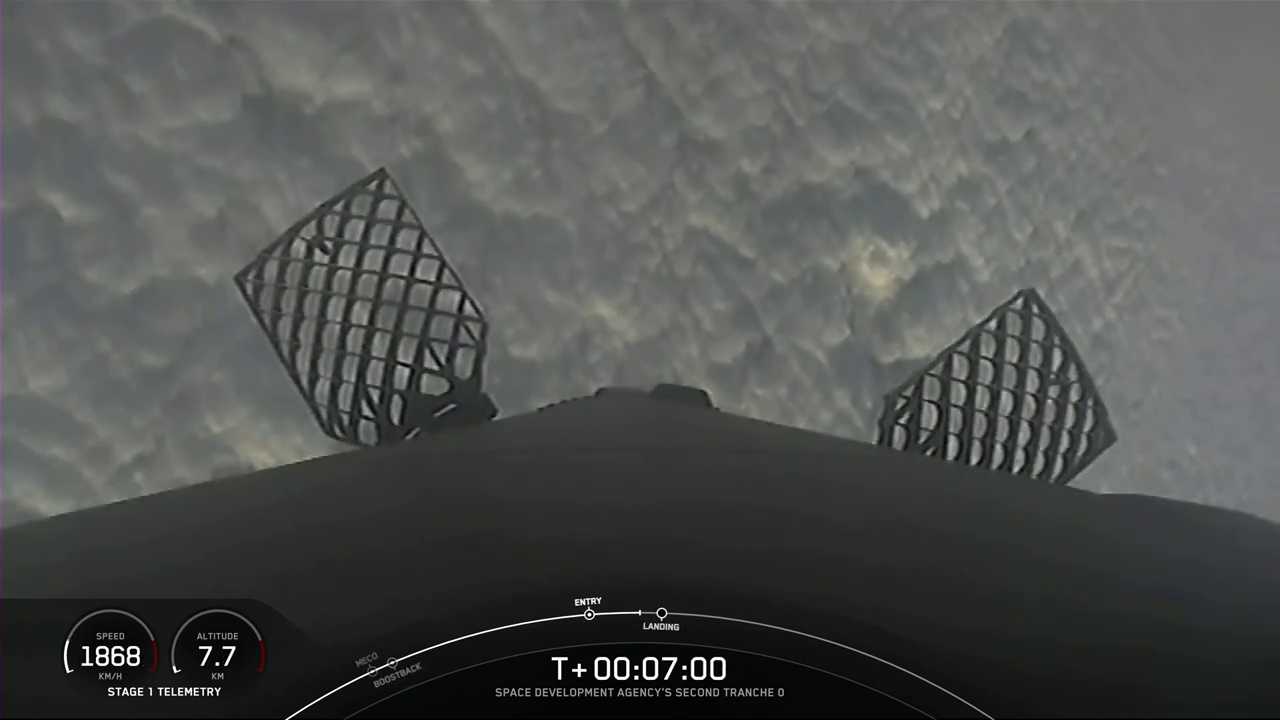

Liftoff registered, now monitoring trajectories...
{'vel': 1864.0, 'alt': 7.7}
{'vel': 1761.0, 'alt': 7.1}
{'vel': 1674.0, 'alt': 6.7}
{'vel': 1594.0, 'alt': 6.3}
{'vel': 1525.0, 'alt': 5.9}
{'vel': 1460.0, 'alt': 5.6}
{'vel': 1404.0, 'alt': 5.3}
{'vel': 1354.0, 'alt': 5.0}
{'vel': 1309.0, 'alt': 4.7}
{'vel': 1271.0, 'alt': 4.4}
{'vel': 1236.0, 'alt': 4.1}
{'vel': 1206.0, 'alt': 3.8}
{'vel': 1181.0, 'alt': 3.5}
{'vel': 1159.0, 'alt': 3.3}
{'vel': 1138.0, 'alt': 3.0}
{'vel': 1117.0, 'alt': 2.7}
{'vel': 1098.0, 'alt': 2.5}
{'vel': 1079.0, 'alt': 2.2}
{'vel': 1062.0, 'alt': 2.0}
{'vel': 1045.0, 'alt': 7.0}
{'vel': 1031.0, 'alt': 1.5}
{'vel': 1011.0, 'alt': 1.3}
{'vel': 963.0, 'alt': 1.0}
{'vel': 795.0, 'alt': 0.8}
{'vel': 604.0, 'alt': 0.7}
{'vel': 422.0, 'alt': 0.6}
{'vel': 318.0, 'alt': 0.5}
{'vel': 282.0, 'alt': 0.4}
{'vel': 254.0, 'alt': 0.3}
{'vel': 224.0, 'alt': 0.3}
{'vel': 189.0, 'alt': 0.2}
{'vel': 156.0, 'alt': 0.2}
{'vel': 135.0, 'alt': 0.2}
{'vel': 114.0, 'alt': 0.1}
{'vel': 9

In [46]:
''' MAIN ROUTINE '''
# Get YouTube Videos
def get_videos_of_playlist(playlist_url):
  return Playlist(playlist_url).video_urls

playlist_url = 'https://www.youtube.com/playlist?list=PLBQ5P5txVQr8qmgRWbVyqhhRzb3Xprefy'
playlist = get_videos_of_playlist(playlist_url)
vidpath = 'temp/launch.mp4'

# Filter out videos which are not launches
blacklist = ['docking', 'undocking']

os.system('mkdir launches')

for url in playlist[:2]:
  # Analyze the current video
  title = YouTube(url).title

  # Skip non-launch videos
  if contains_substring(title.lower(), blacklist):
    continue

  vid, props = get_video(url)
  print(f"Processing video {props['title']} from {props['date']}")

  print('Searching liftoff frame...')
  liftoff_frame = await_liftoff(vid)

  # Skip forward
  #liftoff_frame = liftoff_frame + 7 * 60 * props['fps']

  print('Liftoff registered, now monitoring trajectories...')
  trajectory = process_launch(vid, liftoff_frame)

  # Create a new folder for this launch
  path = f"launches/{props['title'].replace(' ', '_')}"
  os.system(f'mkdir {path}')

  with open(f'{path}/trajectory.csv', 'w') as json_file:
    json.dump(trajectory.to_csv(), json_file)

  create_charts(props['title'], path, trajectory)